<a href="https://colab.research.google.com/github/rzkuppa/cogviewer/blob/main/notebooks/fine-tune-sam-2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-Tune Segment Anything 2.1 (SAM-2.1)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/sam2)

Segment Anything Model is a computer vision from Meta AI that can "cut out" any object, in any image, with a single click.

In September 2024, Meta Research released SAM-2.1 SAM-2.1 is the latest model in the Segment Anything model series. When evaluated against the Segment Anything V test set, the MOSE validation set, and the LVOSv2 dataset, all SAM-2.1 model sizes perform better than SAM-2.

SAM-2.1 was released with training instructions that you can use to fine-tune SAM-2.1 for a specific use case. This is ideal if you want to train SAM-2.1 to segment objects in a specific domain at which the base model struggles.

Here is an example of results from SAM-2, sourced from the Meta SAM-2 GitHub repository:

![segment anything model](https://github.com/facebookresearch/sam2/raw/main/assets/sa_v_dataset.jpg?raw=true)

We recommend that you follow along in this notebook while reading the blog post on [SAM-2.1 fine-tuning](https://blog.roboflow.com/sam-2-1-fine-tuning).

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

Meta recommends training SAM-2.1 on an A100. Thus, if possible, select an A100 GPU in Google Colab for use in training the model.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Download SAM-2.1
- Download Example Data
- Load Model
- Automated Mask Generation

Without further ado, let's get started!

## Download SAM-2.1 and Data

Below, we download SAM-2.1 from GitHub, then download a dataset for use in training. You will need a dataset structured in the correct format for SAM-2.1.

Roboflow supports exporting segmentation datasets to the SAM-2.1 format, ideal for use in this guide. You can upload segmentation datasets in the COCO JSON Segmentation format then convert them to SAM-2.1 for use in this guide.

[Learn how to label a dataset in Roboflow](https://blog.roboflow.com/getting-started-with-roboflow/)

[Learn how to export data from Roboflow for training](https://docs.roboflow.com/datasets/exporting-data).

![Export as SAM-2 data](https://media.roboflow.com/sam2export.png)

We then download a SAM-2.1 training YAML file which we will use to configure our model training job.

Finally, we install SAM-2.1 and download the model checkpoints.

Replace the below code with the code to export your dataset. You can also use the same code above to fine-tune our car parts dataset. _Note: If you use the car parts dataset pre-filled below, you will still need to add a [Roboflow API key](https://docs.roboflow.com/api-reference/authentication#retrieve-an-api-key)._

**Important ⚠️: You must generate a dataset with images stretched to 1024x1024 for training. This is because our training configuration is set to use images of this resolution.**

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uq2sPdwEYncW9v5NZNQk")
project = rf.workspace("kuppa").project("roof-obstructions-unynk")
version = project.version(53)
dataset = version.download("sam2")

# rename dataset.location to "data"
import os
import shutil

# Instead of os.rename, use shutil.rmtree to remove the existing directory if it exists
# and then rename the downloaded dataset directory.
if os.path.exists("/content/data"):
    shutil.rmtree("/content/data")  # Remove the existing directory

os.rename(dataset.location, "/content/data")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Roof-Obstructions-53 in sam2:: 100%|██████████| 614/614 [00:00<00:00, 4564.53it/s]


In [3]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (376/376), done.


In [10]:
!wget -O /content/sam2/sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'

--2025-03-03 16:34:14--  https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.10.132, 2404:6800:4003:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11055 (11K) [application/octet-stream]
Saving to: ‘/content/sam2/sam2/configs/train.yaml’

/content/sam2/sam2/ 100%[===================>]  10.80K  --.-KB/s    in 0s      

2025-03-03 16:34:17 (61.1 MB/s) - ‘/content/sam2/sam2/configs/train.yaml’ saved [11055/11055]



In [11]:
%cd ./sam2/

[Errno 2] No such file or directory: './sam2/'
/content/sam2/sam2


In [13]:
cd ..

/content/sam2


Next, we are going to install SAM-2.

The SAM-2 installation process may take several minutes.

In [14]:
!pip install -e .[dev] -q

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
!pip install torch==2.5.1+cu124 torchaudio==2.5.1+cu124 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.5.1+cu124 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.0+cu121.with.pypi.cudnn, 2.1.0+rocm5.5, 2.1.0+rocm5.6, 2.1.1, 2.1.1+cpu, 2.1.1+cpu.cxx11.abi, 2.1.1+cu118, 2.1.1+cu121, 2.1.1+cu121.with.pypi.cudnn, 2.1.1+rocm5.5, 2.1.1+rocm5.6, 2.1.2, 2.1.2+cpu, 2.1.2+cpu.cxx11.abi, 2.1.2+cu118, 2.1.2+cu121, 2.1.2+cu121.with.pypi.cudnn, 2.1.2+rocm5.5, 2.1.2+rocm5.6, 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0

In [15]:
!cd ./checkpoints && ./download_ckpts.sh

--2025-03-03 16:40:07--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   205MB/s    in 0.7s    

2025-03-03 16:40:08 (205 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-03-03 16:40:08--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1844

## Modify Dataset File Names

SAM-2.1 requires dataset file names to be in a particular format. Run the code snippet below to format your dataset file names as required.

In [19]:
# Script to rename roboflow filenames to something SAM 2.1 compatible.
# Maybe it is possible to remove this step tweaking sam2/sam2/configs/train.yaml.
import os
import re

FOLDER = "/content/data/train"

for filename in os.listdir(FOLDER):
    # Replace all except last dot with underscore
    new_filename = filename.replace(".", "_", filename.count(".") - 1)
    if not re.search(r"_\d+\.\w+$", new_filename):
        # Add an int to the end of base name
        new_filename = new_filename.replace(".", "_1.")
    os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

## Start Training

You can now start training a SAM-2.1 model. The amount of time it will take to train the model will vary depending on the GPU you are using and the number of images in your dataset.

For the car part dataset of 38 images, training on an A100 GPU takes ~15 minutes.

In [ ]:
!python training/train.py -c 'configs/train.yaml' --use-cluster 0 --num-gpus 1

###################### Train App Config ####################
scratch:
  resolution: 1024
  train_batch_size: 1
  num_train_workers: 10
  num_frames: 1
  max_num_objects: 3
  base_lr: 5.0e-06
  vision_lr: 3.0e-06
  phases_per_epoch: 1
  num_epochs: 40
dataset:
  img_folder: /content/data/train
  gt_folder: /content/data/train
  multiplier: 2
vos:
  train_transforms:
  - _target_: training.dataset.transforms.ComposeAPI
    transforms:
    - _target_: training.dataset.transforms.RandomHorizontalFlip
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomAffine
      degrees: 25
      shear: 20
      image_interpolation: bilinear
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomResizeAPI
      sizes: ${scratch.resolution}
      square: true
      consistent_transform: true
    - _target_: training.dataset.transforms.ColorJitter
      consistent_transform: true
      brightness: 0.1
      contrast: 0.03
      saturation: 0.03
   

You can visualize the model training graphs with Tensorboard:

In [ ]:
%load_ext tensorboard
%tensorboard --bind_all --logdir ./sam2_logs/

## Visualize Model Results

With a trained model ready, we can test the model on an image from our test set.

To assist with visualizing model predictions, we are going to use Roboflow supervision, an open source computer vision Python package with utilities for working with vision model outputs


In [ ]:
!pip install supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 4.9 MB/s eta 0:00:00


### Load SAM-2.1

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import supervision as sv
import os
import random
from PIL import Image
import numpy as np

# use bfloat16 for the entire notebook
# from Meta notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

checkpoint = "/content/sam2/sam2_logs/configs/train.yaml/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2)

checkpoint_base = "/content/sam2/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg_base = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)

### Run Inference on an Image in Automatic Mask Generation Mode

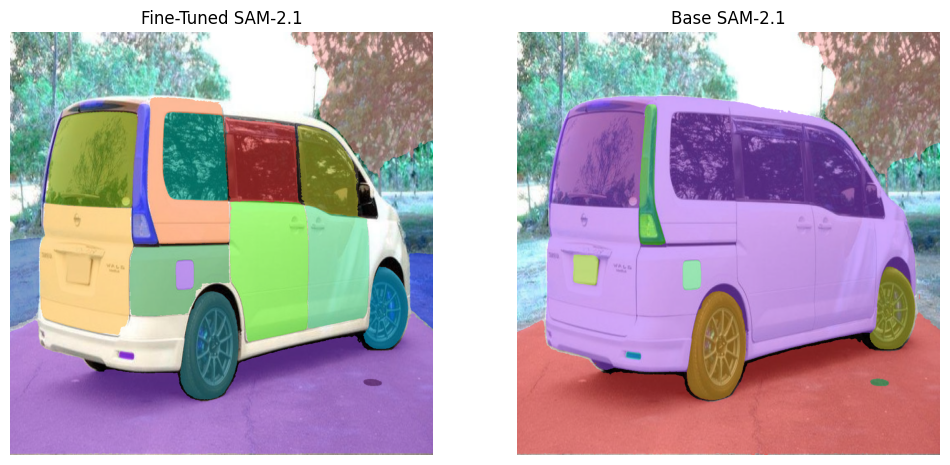

In [ ]:
validation_set = os.listdir("/content/data/valid")

# choose random with .json extension
image = random.choice([img for img in validation_set if img.endswith(".jpg")])
image = os.path.join("/content/data/valid", image)
opened_image = np.array(Image.open(image).convert("RGB"))
result = mask_generator.generate(opened_image)

detections = sv.Detections.from_sam(sam_result=result)

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
annotated_image = opened_image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)

base_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

base_result = mask_generator_base.generate(opened_image)
base_detections = sv.Detections.from_sam(sam_result=base_result)
base_annotated_image = opened_image.copy()
base_annotated_image = base_annotator.annotate(base_annotated_image, detections=base_detections)

sv.plot_images_grid(images=[annotated_image, base_annotated_image], titles=["Fine-Tuned SAM-2.1", "Base SAM-2.1"], grid_size=(1, 2))

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.